In [1]:
from feature_selector import *

import pandas as pd
import numpy as np
import seaborn as sns

from scipy.spatial import distance
from scipy.cluster import hierarchy

import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer

In [2]:
df_ionizable_train: pd.DataFrame = pd.read_csv("../../Data/ionizable_dataset_72_train_divprio.csv", delimiter=';')
df_ionizable_train["TYPE"] = "TRAIN"
df_ionizable_test: pd.DataFrame = pd.read_csv("../../Data/ionizable_dataset_72_test_divprio.csv", delimiter=';')
df_ionizable_test["TYPE"] = "TEST"

df_ionizable = pd.concat([df_ionizable_train, df_ionizable_test])
FS_ionizable: FeatureSelector = FeatureSelector(df_ionizable, cols_to_ignore=["TYPE"])

# FS_io_train.scale_data(inplace=True)
# FS_io_test.scale_data(inplace=True)


df_neutral_train: pd.DataFrame = pd.read_csv("../../Data/neutral_dataset_111_train_divprio.csv", delimiter=';')
df_neutral_train["TYPE"] = "TRAIN"
df_neutral_test: pd.DataFrame = pd.read_csv("../../Data/neutral_dataset_111_test_divprio.csv", delimiter=';')
df_neutral_test["TYPE"] = "TEST"

df_neutral = pd.concat([df_neutral_train, df_neutral_test])
FS_neutral: FeatureSelector = FeatureSelector(df_neutral, cols_to_ignore=["TYPE"])

# FS_ne_train.scale_data(inplace=True)
# FS_ne_test.scale_data(inplace=True)

df_full_train: pd.DataFrame = pd.read_csv("../../Data/full_dataset_train_divprio.csv", delimiter=';')
df_full_train["TYPE"] = "TRAIN"
df_full_test: pd.DataFrame = pd.read_csv("../../Data/full_dataset_test_divprio.csv", delimiter=';')
df_full_test["TYPE"] = "TEST"

df_full = pd.concat([df_full_train, df_full_test])
FS_full: FeatureSelector = FeatureSelector(df_full, cols_to_ignore=["TYPE"])



# FS_full_train: FeatureSelector = FeatureSelector(df_full_train)
# FS_full_test: FeatureSelector = FeatureSelector(df_full_test)

In [3]:
# FS_full.df[["vsurf_W8", "vsurf_HB8"]]
# dropped = FS_full.remove_highly_correlated(verbose=True)

Stats=  3.2222088117322376 
p=  0.19966697887942364
Gaussian


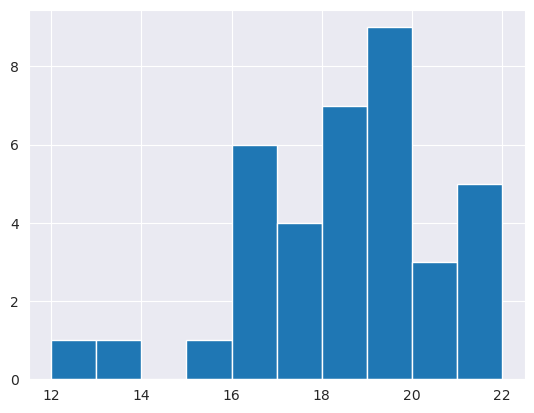

In [4]:
# Test de normalité
from scipy.stats import shapiro, normaltest
from matplotlib import pyplot


data = df_full_test.iloc[:,14]

stat, p = normaltest(data)

print("Stats= ", stat, "\np= ", p)
alpha = 0.05


if p > alpha:
    print("Gaussian")
else:
    print("Not gaussian")


pyplot.hist(data)
pyplot.show()

# Low variance features
We try to detect every feature that has a variance below the threshold

## IONIZABLE

In [5]:
df_ionizable_lv, col_ionizable_lv = FS_ionizable.remove_low_variance(variance_threshold=0, cols_to_ignore=["TYPE"], inplace=True)
print(col_ionizable_lv)
print("length of the feature with low variance that are common for train and test: ", len(col_ionizable_lv))

df_ionizable = df_ionizable.drop(list(col_ionizable_lv), axis=1)


FS_ionizable.get_correlation_to_y()

['a_nB', 'a_nBr', 'a_nI', 'a_nP', 'E_stb', 'MACCS(--1)', 'MACCS(--2)', 'MACCS(--3)', 'MACCS(--4)', 'MACCS(--5)', 'MACCS(--6)', 'MACCS(--7)', 'MACCS(--9)', 'MACCS(-10)', 'MACCS(-12)', 'MACCS(-14)', 'MACCS(-15)', 'MACCS(-17)', 'MACCS(-18)', 'MACCS(-20)', 'MACCS(-21)', 'MACCS(-23)', 'MACCS(-26)', 'MACCS(-27)', 'MACCS(-29)', 'MACCS(-30)', 'MACCS(-31)', 'MACCS(-35)', 'MACCS(-39)', 'MACCS(-40)', 'MACCS(-44)', 'MACCS(-46)', 'MACCS(-48)', 'MACCS(-49)', 'MACCS(-68)', 'MACCS(-69)', 'MACCS(166)', 'nmol', 'vsurf_Wp8']
length of the feature with low variance that are common for train and test:  39


apol           -0.132889
ASA            -0.145405
ASA+            0.099941
ASA-           -0.316285
ASA_H          -0.052910
                  ...   
Weight         -0.185418
weinerPath     -0.200118
weinerPol      -0.187468
zagreb         -0.191985
Log_MP_RATIO    1.000000
Length: 440, dtype: float64

## NEUTRAL

In [6]:
df_neutral_lv, col_neutral_lv = FS_neutral.remove_low_variance(variance_threshold=0, cols_to_ignore=["TYPE"], inplace=True)
print(col_neutral_lv)
print("length of the feature with low variance that are common for train and test: ", len(col_neutral_lv))

df_neutral = df_neutral.drop(list(col_neutral_lv), axis=1)

['a_nB', 'a_nI', 'a_nP', 'E_stb', 'FCharge', 'MACCS(--1)', 'MACCS(--2)', 'MACCS(--3)', 'MACCS(--4)', 'MACCS(--5)', 'MACCS(--6)', 'MACCS(--7)', 'MACCS(--9)', 'MACCS(-10)', 'MACCS(-12)', 'MACCS(-13)', 'MACCS(-14)', 'MACCS(-15)', 'MACCS(-18)', 'MACCS(-20)', 'MACCS(-24)', 'MACCS(-27)', 'MACCS(-29)', 'MACCS(-30)', 'MACCS(-31)', 'MACCS(-34)', 'MACCS(-35)', 'MACCS(-39)', 'MACCS(-40)', 'MACCS(-41)', 'MACCS(-44)', 'MACCS(-48)', 'MACCS(-49)', 'MACCS(-68)', 'MACCS(166)', 'nmol']
length of the feature with low variance that are common for train and test:  36


## FULL

In [7]:
print(FS_full.df.shape)
df_full_lv, col_full_lv = FS_full.remove_low_variance(variance_threshold=0, cols_to_ignore=["TYPE"], inplace=True)
print(col_full_lv)
print("length of the feature with low variance that are common for train and test: ", len(col_full_lv))
df_full = df_full.drop(list(col_full_lv), axis=1)
print(FS_full.df.shape)


(183, 480)
['a_nB', 'a_nI', 'a_nP', 'E_stb', 'MACCS(--1)', 'MACCS(--2)', 'MACCS(--3)', 'MACCS(--4)', 'MACCS(--5)', 'MACCS(--6)', 'MACCS(--7)', 'MACCS(--9)', 'MACCS(-10)', 'MACCS(-12)', 'MACCS(-14)', 'MACCS(-15)', 'MACCS(-18)', 'MACCS(-20)', 'MACCS(-27)', 'MACCS(-29)', 'MACCS(-30)', 'MACCS(-31)', 'MACCS(-35)', 'MACCS(-39)', 'MACCS(-40)', 'MACCS(-44)', 'MACCS(-48)', 'MACCS(-68)', 'MACCS(166)', 'nmol']
length of the feature with low variance that are common for train and test:  30
(183, 450)


# Detect binary data

In [8]:
from sklearn.feature_selection import VarianceThreshold

dfs: dict = {
    "ionizable": df_ionizable.loc[:, df_ionizable.isin([0,1]).all()],
    "neutral": df_neutral.loc[:, df_neutral.isin([0,1]).all()],
    "full": df_full.loc[:, df_full.isin([0,1]).all()]
}


for key, value in dfs.items():
    suspect_cols = []
    for i in range(value.shape[1]):
        aled = value[value.columns[i]].value_counts()
        percentage = aled.min() / aled.sum() * 100
        if (percentage < 1).any():
            suspect_cols.append(aled)
    print("===== ", key, " =====")
    print(suspect_cols)


=====  ionizable  =====
[]
=====  neutral  =====
[b_triple
0    110
1      1
Name: count, dtype: int64, MACCS(--8)
0    110
1      1
Name: count, dtype: int64, MACCS(-16)
0    110
1      1
Name: count, dtype: int64, MACCS(-21)
0    110
1      1
Name: count, dtype: int64, MACCS(-23)
0    110
1      1
Name: count, dtype: int64]
=====  full  =====
[MACCS(-13)
0    182
1      1
Name: count, dtype: int64, MACCS(-21)
0    182
1      1
Name: count, dtype: int64, MACCS(-23)
0    182
1      1
Name: count, dtype: int64, MACCS(-34)
0    182
1      1
Name: count, dtype: int64]


# High correlation feature

## IONIZABLE

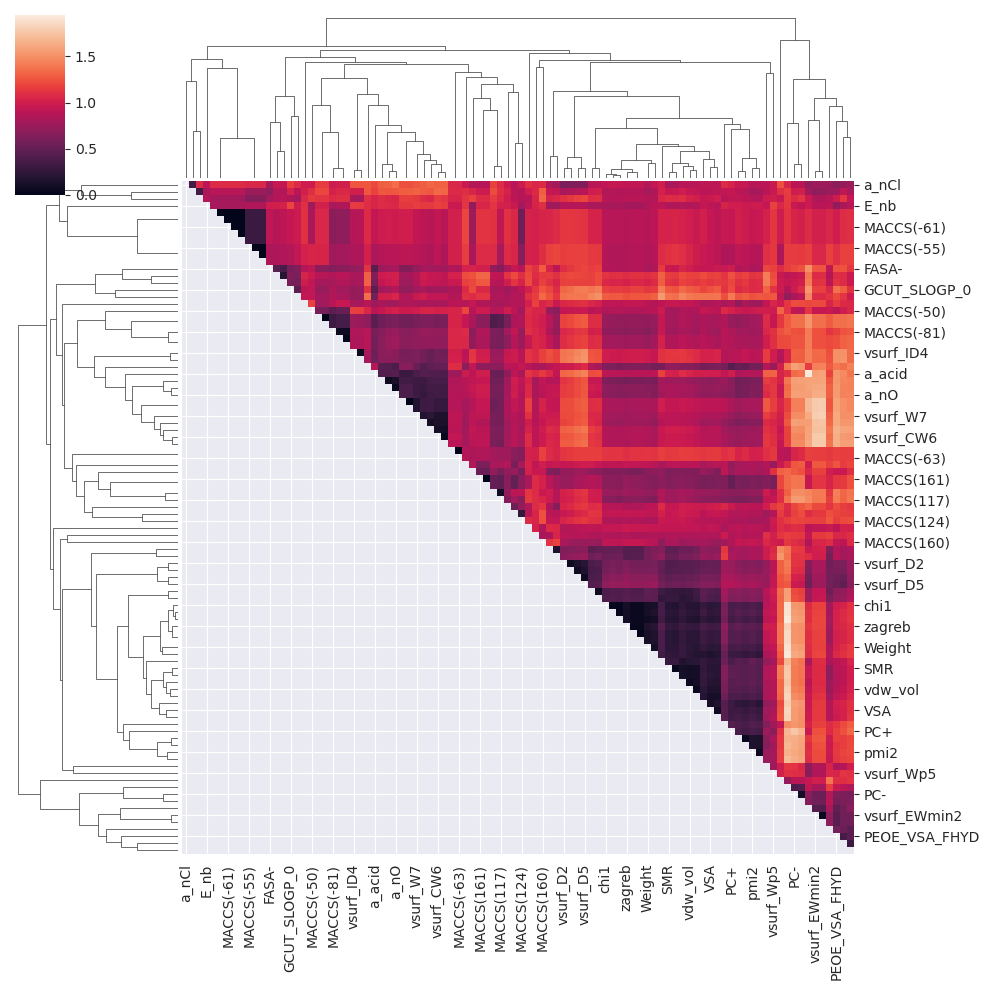

In [9]:
df_ionizable_correlation_removed = FS_ionizable.remove_highly_correlated(graph=True)

## Neutral

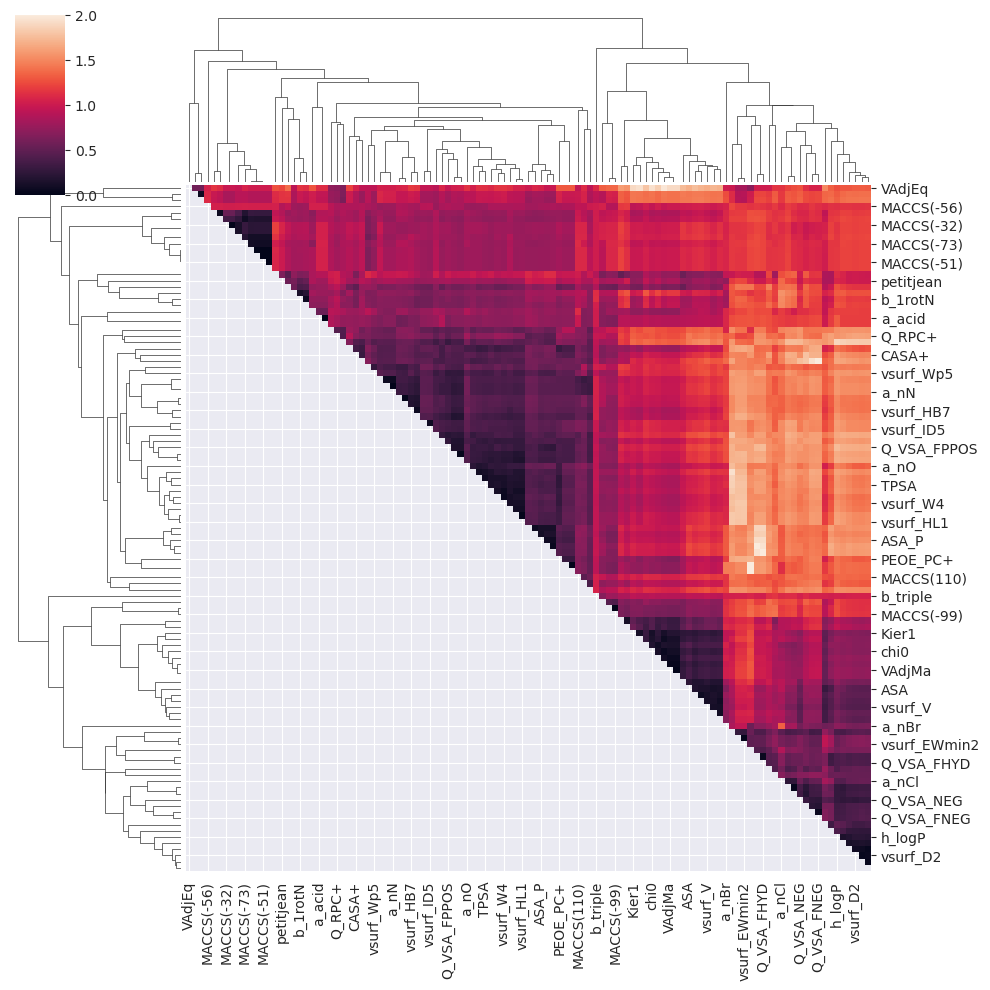

In [10]:
df_neutral_correlation_removed = FS_neutral.remove_highly_correlated(graph=True)


## Full

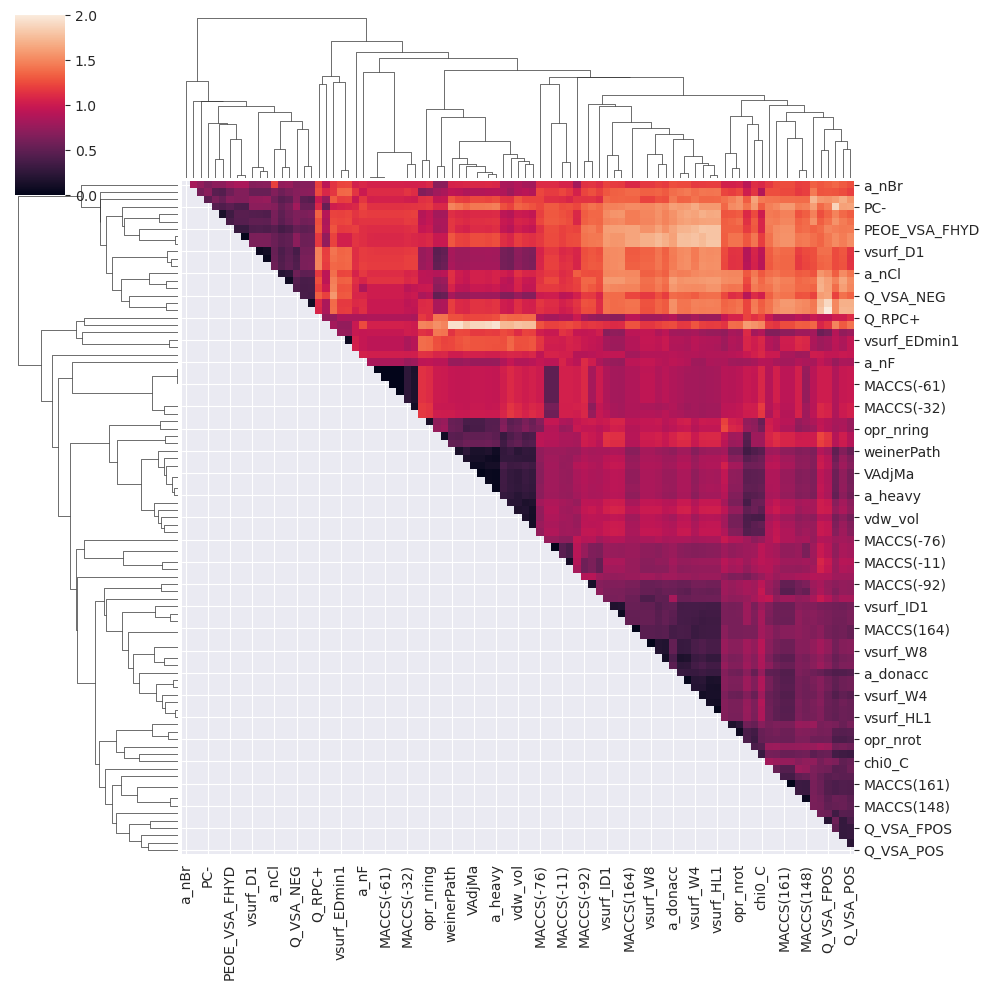

In [11]:
df_full_correlation_removed = FS_full.remove_highly_correlated(graph=True)

# Proof of concept of the **transform** method

In [12]:
# Loading the data and putting it in a FeatureSelector object
df_full_train: pd.DataFrame = pd.read_csv("../../Data/full_dataset_train_divprio.csv", delimiter=';')
df_full_train["TYPE"] = "TRAIN"
df_full_test: pd.DataFrame = pd.read_csv("../../Data/full_dataset_test_divprio.csv", delimiter=';')
df_full_test["TYPE"] = "TEST"

df_full = pd.concat([df_full_train, df_full_test])
FS_full: FeatureSelector = FeatureSelector(df_full, cols_to_ignore=["TYPE"])

In [13]:
# Calling the automatic selection function
final_df: pd.DataFrame = FS_full.transform()

In [14]:
final_df.equals(df_full_correlation_removed)

True